# Step 1 ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- 

In [12]:
import os
import time
import uuid
import cv2
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt
import albumentations as alb

In [13]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [9]:
# NOTE --> I ran the below code (gpt edited code) 3 times one after the other, and i got a total of 90 pictures.

# Original -->

'''
cap = cv2.VideoCapture(1)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()
'''

# ===== ===== ===== ===== ===== ===== ===== ===== ===== =====

# GPT Edited/Fixed -->

IMAGES_PATH = r"C:\Users\sun24\Jp Folder\Test\03 - Build a Deep Face Detection Model with Python and Tensorflow\data\images"
number_images = 30  # Adjust this to the desired number of images

cap = cv2.VideoCapture(0)  # Assuming only one camera is connected

for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))

    # Allow the camera to adjust and capture a frame
    time.sleep(1)

    ret, frame = cap.read()
    print('Frame read successful:', ret)

    if ret:
        imgname = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')
        cv2.imwrite(imgname, frame)
        cv2.imshow('frame', frame)
        time.sleep(0.5)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

Frame read successful: True
Frame read successful: True
Frame read successful: True
Frame read successful: True
Frame read successful: True
Frame read successful: True
Frame read successful: True
Frame read successful: True
Frame read successful: True
Frame read successful: True
Frame read successful: True
Frame read successful: True
Frame read successful: True
Frame read successful: True
Frame read successful: True
Frame read successful: True
Frame read successful: True
Frame read successful: True
Frame read successful: True
Frame read successful: True
Frame read successful: True
Frame read successful: True
Frame read successful: True
Frame read successful: True
Frame read successful: True
Frame read successful: True
Frame read successful: True
Frame read successful: True
Frame read successful: True
Frame read successful: True


In [10]:
!labelme

2024-01-05 02:54:42,638 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\sun24\.labelmerc


# Step 2 ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- 

In [14]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [15]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [16]:
images.as_numpy_iterator().next()

b'data\\images\\7b0924cb-ab47-11ee-b0c6-e848b8c82000.jpg'

In [17]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [18]:
images = images.map(load_image)

In [19]:
images.as_numpy_iterator().next()

array([[[148, 136, 110],
        [156, 144, 118],
        [159, 149, 122],
        ...,
        [148, 199, 218],
        [145, 196, 215],
        [141, 194, 212]],

       [[152, 140, 118],
        [158, 146, 122],
        [160, 148, 124],
        ...,
        [145, 196, 215],
        [143, 196, 214],
        [141, 197, 214]],

       [[158, 142, 127],
        [161, 145, 129],
        [162, 146, 130],
        ...,
        [141, 194, 212],
        [140, 195, 215],
        [140, 197, 216]],

       ...,

       [[ 31,  30,  25],
        [ 27,  26,  21],
        [ 24,  25,  19],
        ...,
        [116, 169, 183],
        [115, 168, 182],
        [116, 170, 182]],

       [[ 29,  28,  26],
        [ 26,  25,  23],
        [ 23,  23,  21],
        ...,
        [120, 169, 183],
        [121, 169, 183],
        [121, 169, 181]],

       [[ 26,  24,  25],
        [ 25,  23,  24],
        [ 23,  23,  23],
        ...,
        [122, 170, 184],
        [123, 169, 182],
        [122, 168, 181]]

In [20]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

In [21]:
image_generator = images.batch(4).as_numpy_iterator()

In [22]:
plot_images = image_generator.next()

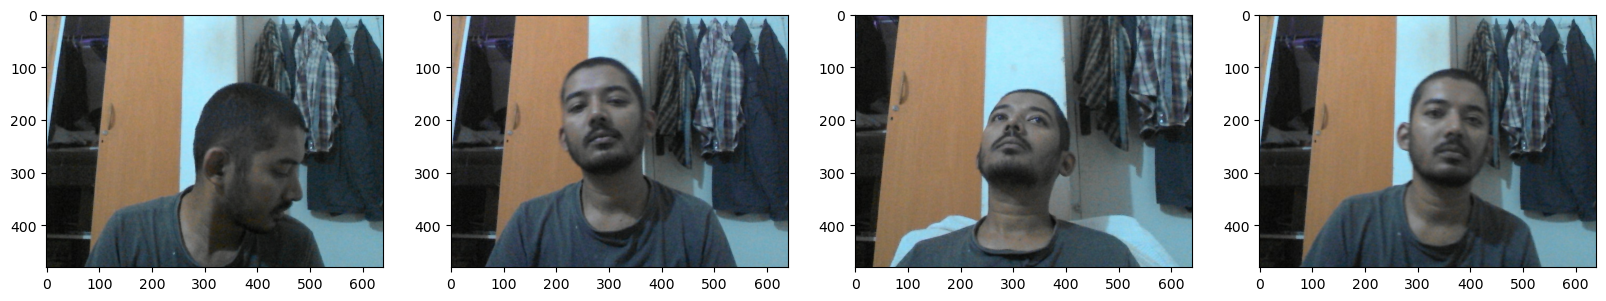

In [23]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# Step 3 ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- 

In [24]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

# Step 4 ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- 

In [25]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [26]:
img = cv2.imread(os.path.join('data','train', 'images','1c061c59-ab47-11ee-897b-e848b8c82000.jpg'))

In [27]:
with open(os.path.join('data', 'train', 'labels', '1c061c59-ab47-11ee-897b-e848b8c82000.json'), 'r') as f:
    label = json.load(f)

In [28]:
label['shapes'][0]['points']

[[210.78947368421052, 85.39473684210526],
 [410.13157894736844, 307.10526315789474]]

In [29]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [30]:
coords

[210.78947368421052, 85.39473684210526, 410.13157894736844, 307.10526315789474]

In [31]:
coords = list(np.divide(coords, [640,480,640,480]))

In [32]:
coords

[0.3293585526315789,
 0.17790570175438597,
 0.6408305921052632,
 0.6398026315789473]

In [33]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [34]:
augmented['bboxes'][0][2:]

(0.7091812865497077, 0.6357894736842106)

In [35]:
augmented['bboxes']

[(0.2661988304093567,
  0.14309941520467837,
  0.7091812865497077,
  0.6357894736842106)]

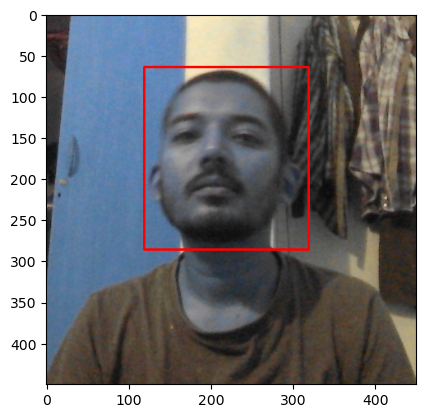

In [36]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# Step 5 ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- 

In [37]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

In [38]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [39]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [40]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [41]:
train_images.as_numpy_iterator().next()

array([[[0.16672795, 0.17457108, 0.16280638],
        [0.22034314, 0.22340687, 0.22310048],
        [0.19221814, 0.19613971, 0.20398284],
        ...,
        [0.08872549, 0.09442402, 0.09595589],
        [0.09675245, 0.10459559, 0.08756127],
        [0.07291666, 0.07585784, 0.07254902]],

       [[0.1627451 , 0.16311274, 0.15545343],
        [0.2408701 , 0.24840686, 0.24589461],
        [0.20778187, 0.21317402, 0.22052696],
        ...,
        [0.09963235, 0.10655637, 0.09509804],
        [0.07769608, 0.08541667, 0.08057598],
        [0.09080882, 0.09227941, 0.09522059]],

       [[0.15557598, 0.17242648, 0.16145833],
        [0.27512255, 0.29865196, 0.29865196],
        [0.22414216, 0.24375   , 0.2555147 ],
        ...,
        [0.09460784, 0.09460784, 0.08676471],
        [0.09852941, 0.09852941, 0.09754902],
        [0.09191176, 0.09485294, 0.09338235]],

       ...,

       [[0.22573529, 0.2930147 , 0.3235907 ],
        [0.22751226, 0.2817402 , 0.31666666],
        [0.21464461, 0

# Step 6 ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- 

In [42]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [43]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [44]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [45]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [46]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.0798, 0.2688, 0.556 , 0.734 ], dtype=float16))

# Step 7 ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- 

In [47]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3780, 3780, 840, 840, 780, 780)

In [48]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [49]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [50]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [51]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.2388 , 0.2181 , 0.68   , 0.752  ],
        [0.1682 , 0.2153 , 0.648  , 0.746  ],
        [0.3318 , 0.2378 , 0.8364 , 0.8735 ],
        [0.451  , 0.1747 , 0.8765 , 0.716  ],
        [0.2185 , 0.2045 , 0.7227 , 0.8403 ],
        [0.7563 , 0.1685 , 1.     , 0.7197 ],
        [0.06915, 0.2025 , 0.5503 , 0.771  ],
        [0.1003 , 0.2291 , 0.581  , 0.798  ]], dtype=float16))

In [52]:
data_samples = train.as_numpy_iterator()

In [ ]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


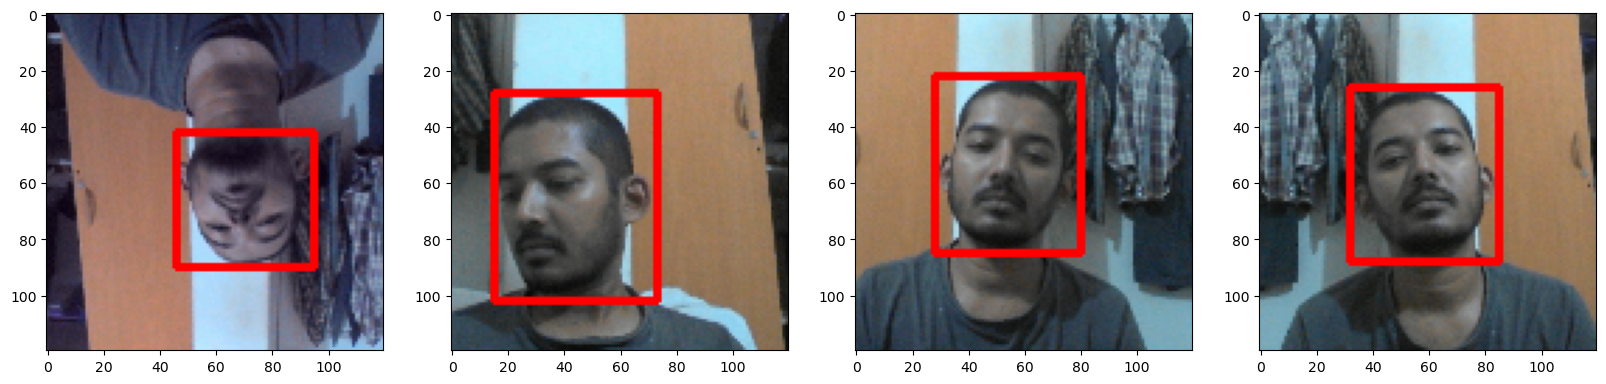

In [56]:
# Original -->

'''
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)
'''

# ===== ===== ===== ===== ===== ===== ===== ===== ===== =====

# GPT Edited/Fixed -->
 
import cv2
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=4, figsize=(20, 20))

for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]

    # Convert the NumPy array to a UMat
    sample_image_umat = cv2.UMat(sample_image)

    cv2.rectangle(sample_image_umat,
                  tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)),
                  (255, 0, 0), 2)

    # Convert the UMat back to a NumPy array for displaying with Matplotlib
    sample_image_with_rectangle = cv2.UMat.get(sample_image_umat)

    ax[idx].imshow(sample_image_with_rectangle)

plt.show()

# Step 8 ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- 

In [57]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [58]:
vgg = VGG16(include_top=False)



58889256/58889256 [==============================] - 12s 0us/step


In [59]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [60]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [61]:
facetracker = build_model()

In [62]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_2[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d (Glob  (None, 512)                  0         ['vgg16[0][0]']               
 alMaxPooling2D)                                                                                  
                                                                                              

In [63]:
X, y = train.as_numpy_iterator().next()

In [64]:
X.shape

(8, 120, 120, 3)

In [65]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 5s 5s/step


In [66]:
classes, coords

(array([[0.39876935],
        [0.36785558],
        [0.45304075],
        [0.37468675],
        [0.3866001 ],
        [0.3729609 ],
        [0.3970197 ],
        [0.36954254]], dtype=float32),
 array([[0.42379543, 0.5654393 , 0.74556303, 0.40481338],
        [0.5135281 , 0.5228969 , 0.7427782 , 0.39257842],
        [0.4059961 , 0.5469324 , 0.71906185, 0.44361892],
        [0.44473347, 0.5422684 , 0.7019851 , 0.4040187 ],
        [0.3839539 , 0.5058646 , 0.73393285, 0.41983908],
        [0.4621608 , 0.6147154 , 0.725477  , 0.38518697],
        [0.47609407, 0.56745464, 0.6996328 , 0.42030504],
        [0.4479154 , 0.5983642 , 0.73052984, 0.42916676]], dtype=float32))

# Step 9 ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- 

In [67]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [69]:
# Original -->

# opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

# ===== ===== ===== ===== ===== ===== ===== ===== ===== =====

# GPT Edited/Fixed -->

initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,  # Adjust this based on your requirements
    decay_rate=0.9,
    staircase=True)

opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [70]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [71]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [72]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.155017>

In [73]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.9435973>

In [74]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.155017>

# Step 10 ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- 

In [75]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [76]:
model = FaceTracker(facetracker)

In [77]:
model.compile(opt, classloss, regressloss)

In [78]:
logdir='logs'

In [79]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [80]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
473/473 [==============================] - 4102s 9s/step - total_loss: 0.0699 - class_loss: 0.0076 - regress_loss: 0.0661 - val_total_loss: 0.0058 - val_class_loss: 1.6838e-05 - val_regress_loss: 0.0058
Epoch 2/10
473/473 [==============================] - 3486s 7s/step - total_loss: 0.0072 - class_loss: 3.2108e-06 - regress_loss: 0.0072 - val_total_loss: 0.0060 - val_class_loss: 1.3560e-06 - val_regress_loss: 0.0060
Epoch 3/10
473/473 [==============================] - 3596s 8s/step - total_loss: 0.0046 - class_loss: 9.8005e-07 - regress_loss: 0.0046 - val_total_loss: 0.0047 - val_class_loss: 2.9802e-07 - val_regress_loss: 0.0047
Epoch 4/10
473/473 [==============================] - 3488s 7s/step - total_loss: 0.0042 - class_loss: 4.7075e-07 - regress_loss: 0.0042 - val_total_loss: 0.0088 - val_class_loss: 1.0431e-06 - val_regress_loss: 0.0088
Epoch 5/10
473/473 [==============================] - 5332s 11s/step - total_loss: 0.0034 - class_loss: 2.6855e-07 - regress_loss: 0

In [81]:
hist.history

{'total_loss': [0.0038568866439163685,
  0.006243247538805008,
  0.0017779734916985035,
  0.004034086596220732,
  0.0026412932202219963,
  0.005260918289422989,
  0.0011281620245426893,
  0.0004637297533918172,
  0.002178892493247986,
  0.0025494880974292755],
 'class_loss': [3.3170843380503356e-05,
  1.356007601316378e-06,
  1.9371513815258368e-07,
  2.980233091420814e-07,
  1.1920930376163597e-07,
  4.470348713425665e-08,
  1.0430814967321567e-07,
  1.788139627478813e-07,
  2.980232594040899e-08,
  0.0],
 'regress_loss': [0.0038403011858463287,
  0.006242569535970688,
  0.0017778766341507435,
  0.004033937584608793,
  0.002641233615577221,
  0.005260895937681198,
  0.0011281098704785109,
  0.0004636403464246541,
  0.002178877592086792,
  0.0025494880974292755],
 'val_total_loss': [0.005800136364996433,
  0.005976521410048008,
  0.004710062872618437,
  0.008788933046162128,
  0.0044137947261333466,
  0.003094813786447048,
  0.0048255715519189835,
  0.004176443908363581,
  0.0022733882

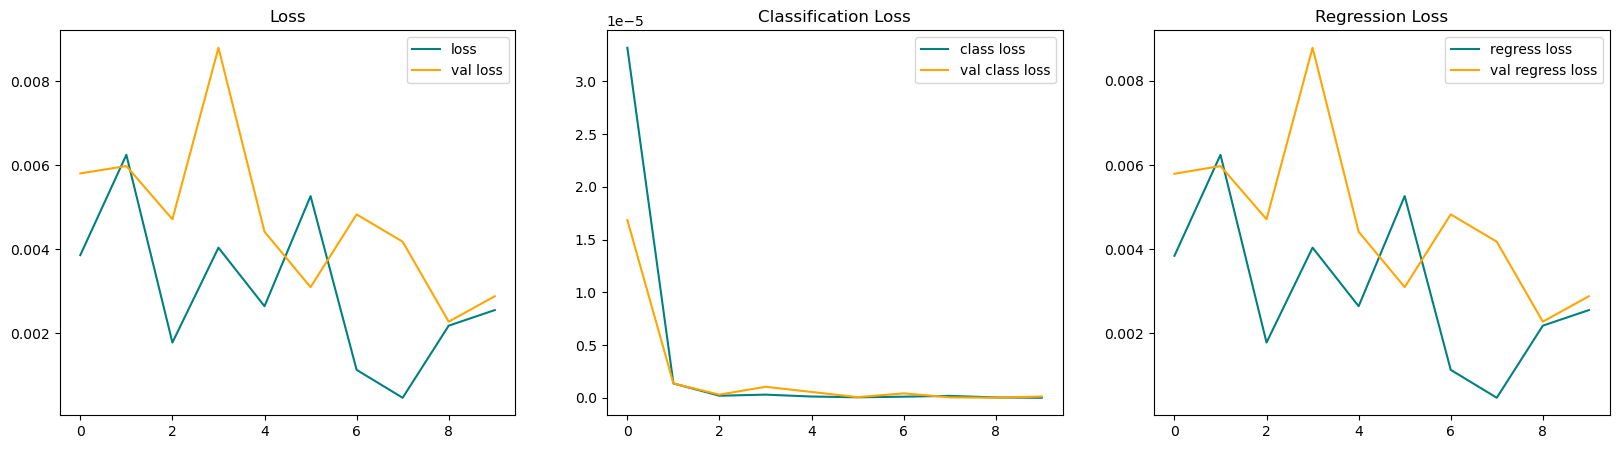

In [82]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# Step 11 ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- 

In [83]:
test_data = test.as_numpy_iterator()

In [84]:
test_sample = test_data.next()

In [85]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 4s 4s/step


error: OpenCV(4.9.0) :-1: error: (-5:Bad argument) in function 'rectangle'
> Overload resolution failed:
>  - img marked as output argument, but provided NumPy array marked as readonly
>  - Expected Ptr<cv::UMat> for argument 'img'
>  - img marked as output argument, but provided NumPy array marked as readonly
>  - Expected Ptr<cv::UMat> for argument 'img'


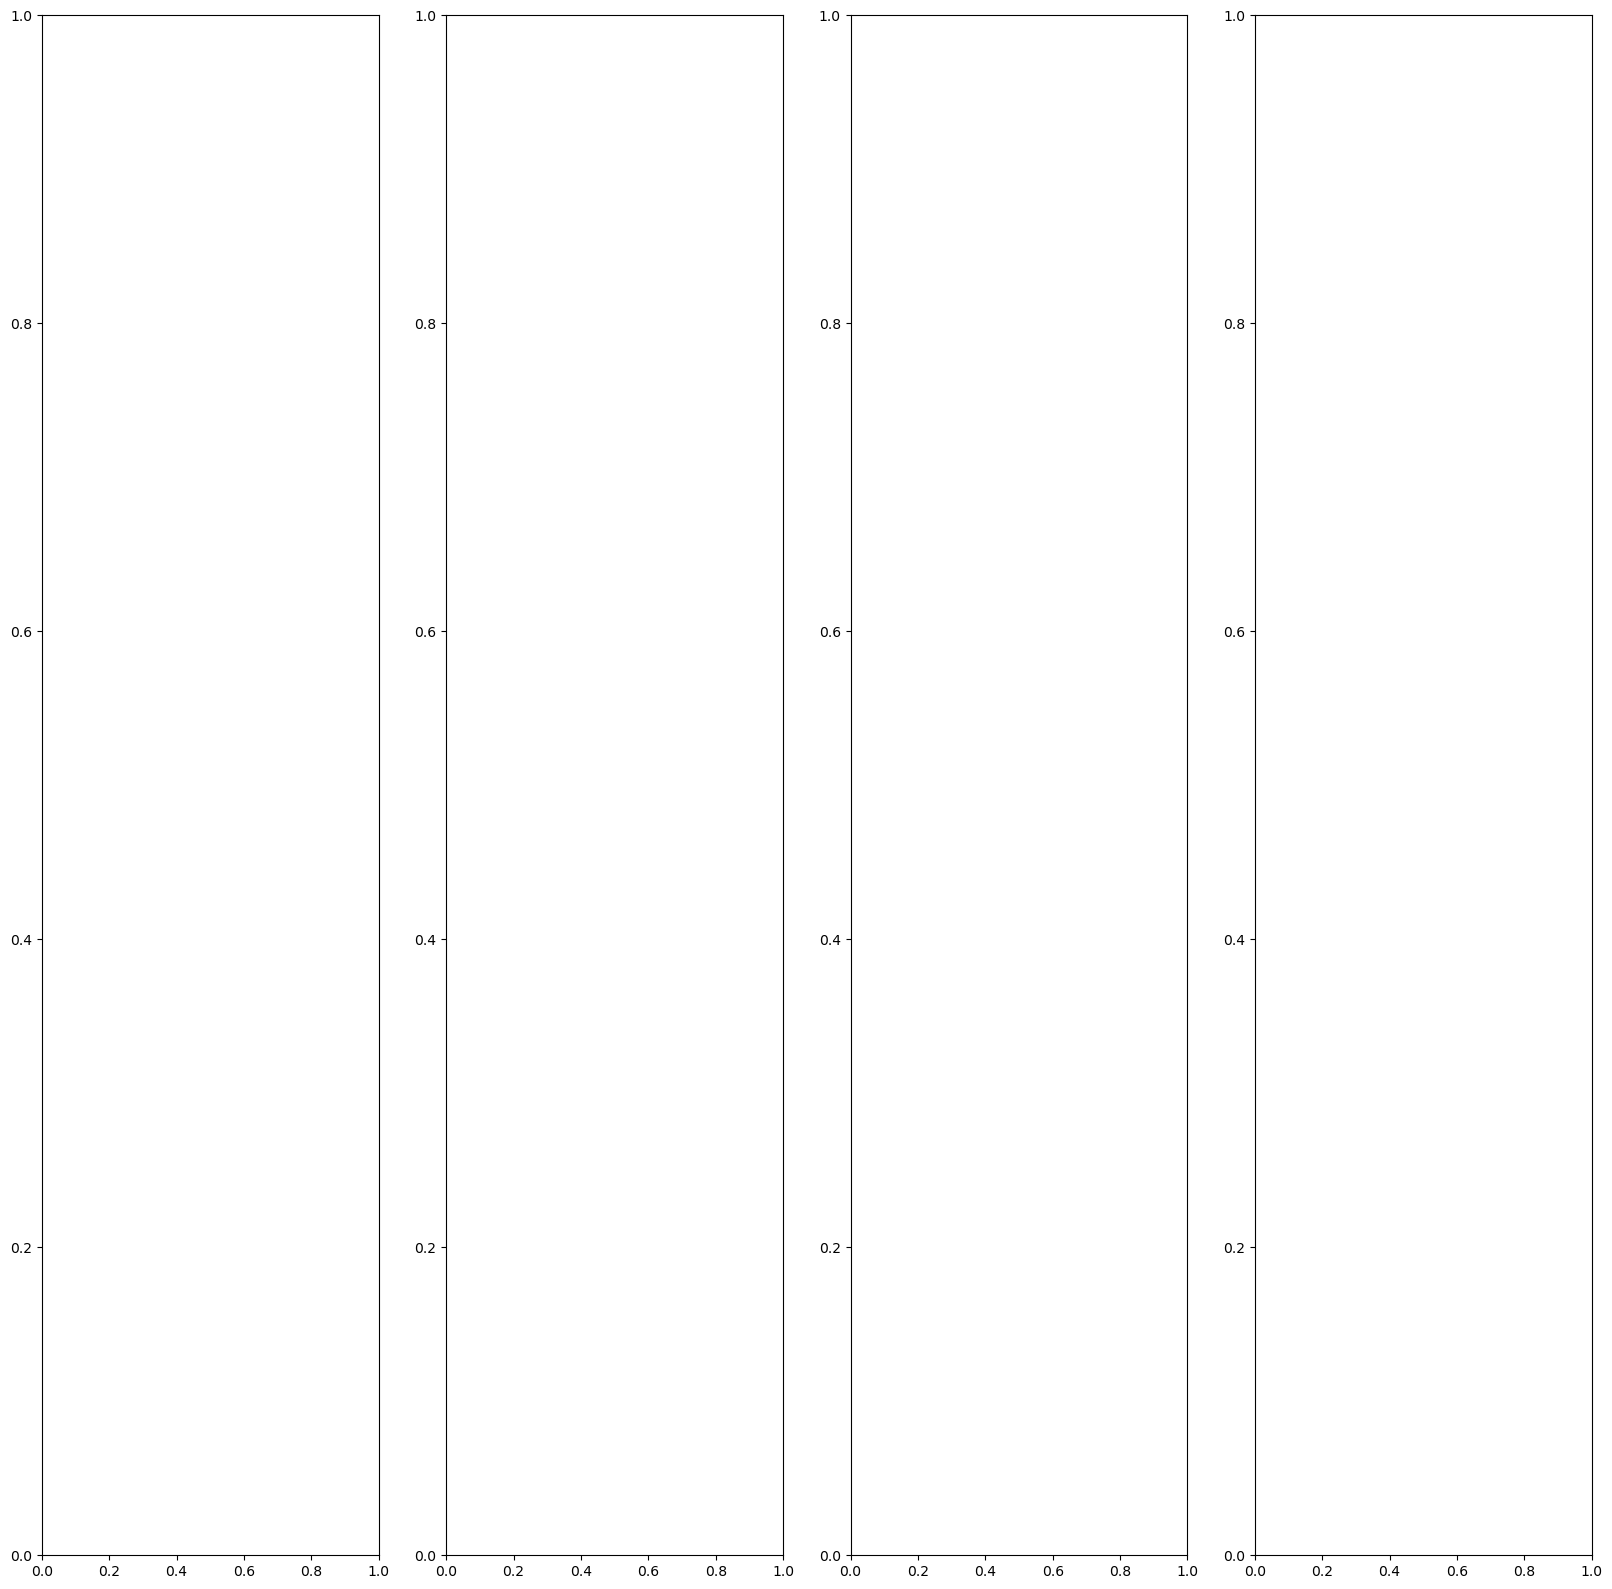

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


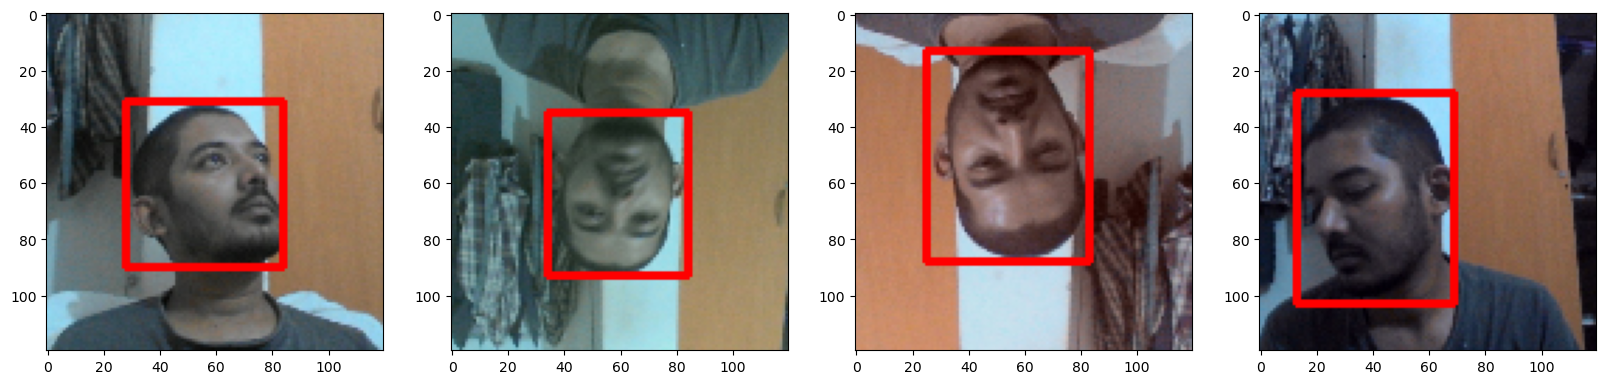

In [88]:
# Original -->

'''
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)
'''

# ===== ===== ===== ===== ===== ===== ===== ===== ===== =====

# GPT Edited/Fixed -->

import cv2
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=4, figsize=(20, 20))

for idx in range(4):
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]

    # Convert NumPy array to cv::UMat
    sample_image = cv2.UMat(sample_image)

    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image,
                      tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)),
                      (255, 0, 0), 2)

    # Convert cv::UMat back to NumPy array for imshow
    ax[idx].imshow(cv2.UMat.get(sample_image))

plt.show()

In [89]:
from tensorflow.keras.models import load_model

In [93]:
# Original -->

# facetracker.save('facetracker.h5')

# ===== ===== ===== ===== ===== ===== ===== ===== ===== =====

# GPT Edited/Fixed -->

facetracker.save('facetracker.keras')

In [94]:
# Original -->

# facetracker = load_model('facetracker.h5')

# ===== ===== ===== ===== ===== ===== ===== ===== ===== =====

# GPT Edited/Fixed -->

facetracker = load_model('facetracker.keras')

In [95]:
cap = cv2.VideoCapture(1)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [96]:
cap = cv2.VideoCapture(1)

while cap.isOpened():
    _, frame = cap.read()
    frame = frame[50:500, 50:500, :]

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120, 120))

    yhat = facetracker.predict(np.expand_dims(resized / 255, 0))
    sample_coords = yhat[1][0]
    face_probability = yhat[0][0]

    print(f"Face Probability: {face_probability}")
    print(f"Sample Coordinates: {sample_coords}")

    if face_probability > 0.5:
        # Your existing code for drawing rectangles and text

    cv2.imshow('EyeTrack', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

IndentationError: expected an indented block after 'if' statement on line 17 (3308342601.py, line 20)

In [97]:
cap = cv2.VideoCapture(1)

while cap.isOpened():
    _, frame = cap.read()
    frame = frame[50:500, 50:500, :]

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120, 120))

    yhat = facetracker.predict(np.expand_dims(resized / 255, 0))
    sample_coords = yhat[1][0]
    face_probability = yhat[0][0]

    print(f"Face Probability: {face_probability}")
    print(f"Sample Coordinates: {sample_coords}")

    if face_probability > 0.5:
        # Your existing code for drawing rectangles and text
        cv2.rectangle(frame,
                      tuple(np.multiply(sample_coords[:2], [450, 450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450, 450]).astype(int)),
                      (255, 0, 0), 2)
        cv2.rectangle(frame,
                      tuple(np.add(np.multiply(sample_coords[:2], [450, 450]).astype(int),
                                   [0, -30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450, 450]).astype(int),
                                   [80, 0])),
                      (255, 0, 0), -1)
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450, 450]).astype(int),
                                                [0, -5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    cv2.imshow('EyeTrack', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


In [98]:
cap = cv2.VideoCapture(1)

while cap.isOpened():
    _, frame = cap.read()
    frame = frame[50:500, 50:500, :]

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120, 120))

    yhat = facetracker.predict(np.expand_dims(resized / 255, 0))
    sample_coords = yhat[1][0]
    face_probability = yhat[0][0]

    print(f"Face Probability: {face_probability}")
    print(f"Sample Coordinates: {sample_coords}")

    if face_probability > 0.5:
        print("Face detected!")

        # Your existing code for drawing rectangles and text
        cv2.rectangle(frame,
                      tuple(np.multiply(sample_coords[:2], [450, 450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450, 450]).astype(int)),
                      (255, 0, 0), 2)
        cv2.rectangle(frame,
                      tuple(np.add(np.multiply(sample_coords[:2], [450, 450]).astype(int),
                                   [0, -30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450, 450]).astype(int),
                                   [80, 0])),
                      (255, 0, 0), -1)
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450, 450]).astype(int),
                                                [0, -5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    print(frame.shape)  # Print the shape of the captured frame

    cv2.imshow('EyeTrack', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


In [99]:
cv2.imshow('EyeTrack', frame)
cv2.waitKey(1)
time.sleep(0.1)  # Add a small delay
